
== STRATEGY COMPARISON (LAST 5 ROWS) ==

                            MACD            RSI          ATR          Stoch  \
Date                                                                          
2025-10-02 22:13:02  99515.98853  100734.002451  101199.9365  101932.390064   
2025-10-02 22:23:21  99515.98853  100734.002451  101199.9365  101936.576715   
2025-10-02 22:33:44  99515.98853  100734.002451  101199.9365  101949.136668   
2025-10-02 22:44:06  99515.98853  100734.002451  101199.9365  101944.950017   
2025-10-02 22:54:22  99515.98853  100734.002451  101199.9365  101949.136668   

                           BuyHold  
Date                                
2025-10-02 22:13:02  102436.048469  
2025-10-02 22:23:21  102440.255806  
2025-10-02 22:33:44  102452.877819  
2025-10-02 22:44:06  102448.670481  
2025-10-02 22:54:22  102452.877819  


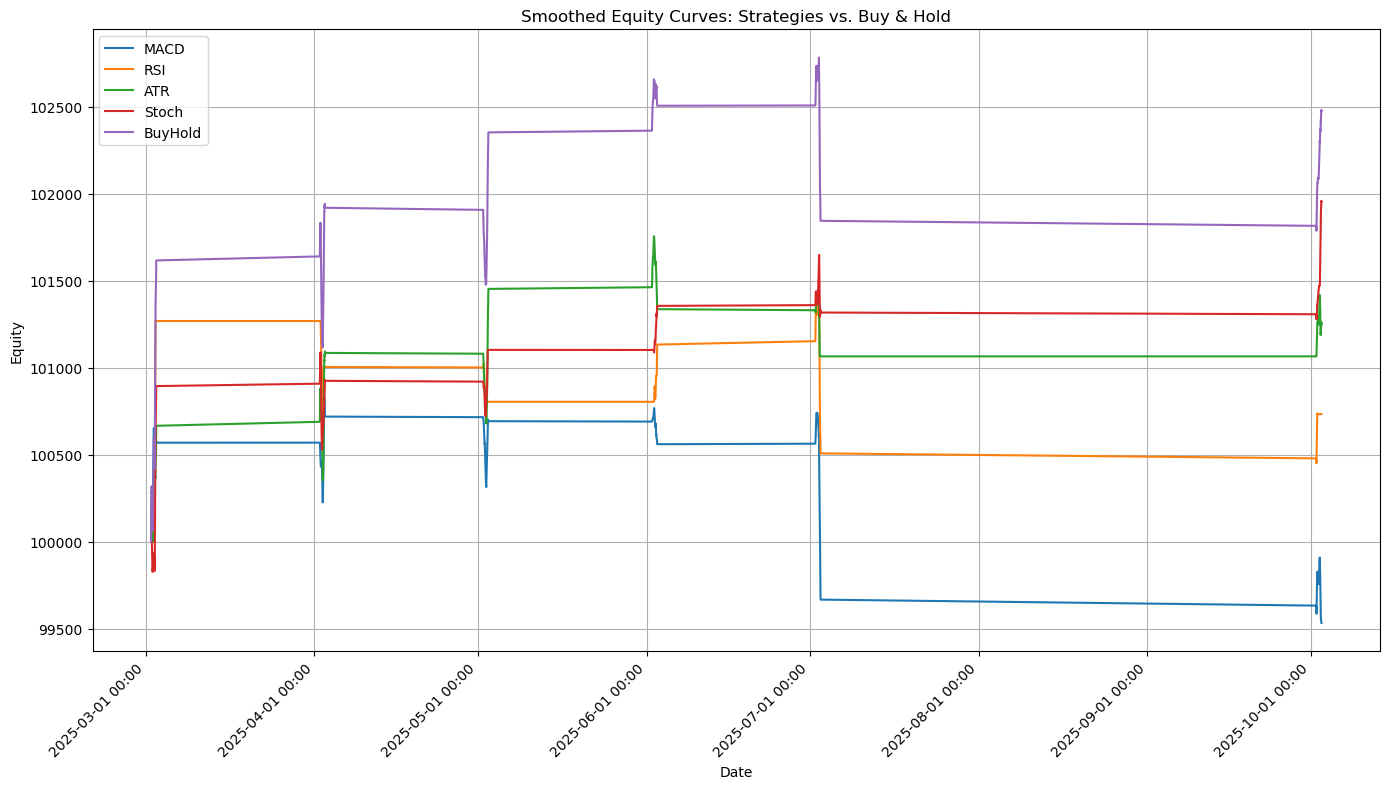

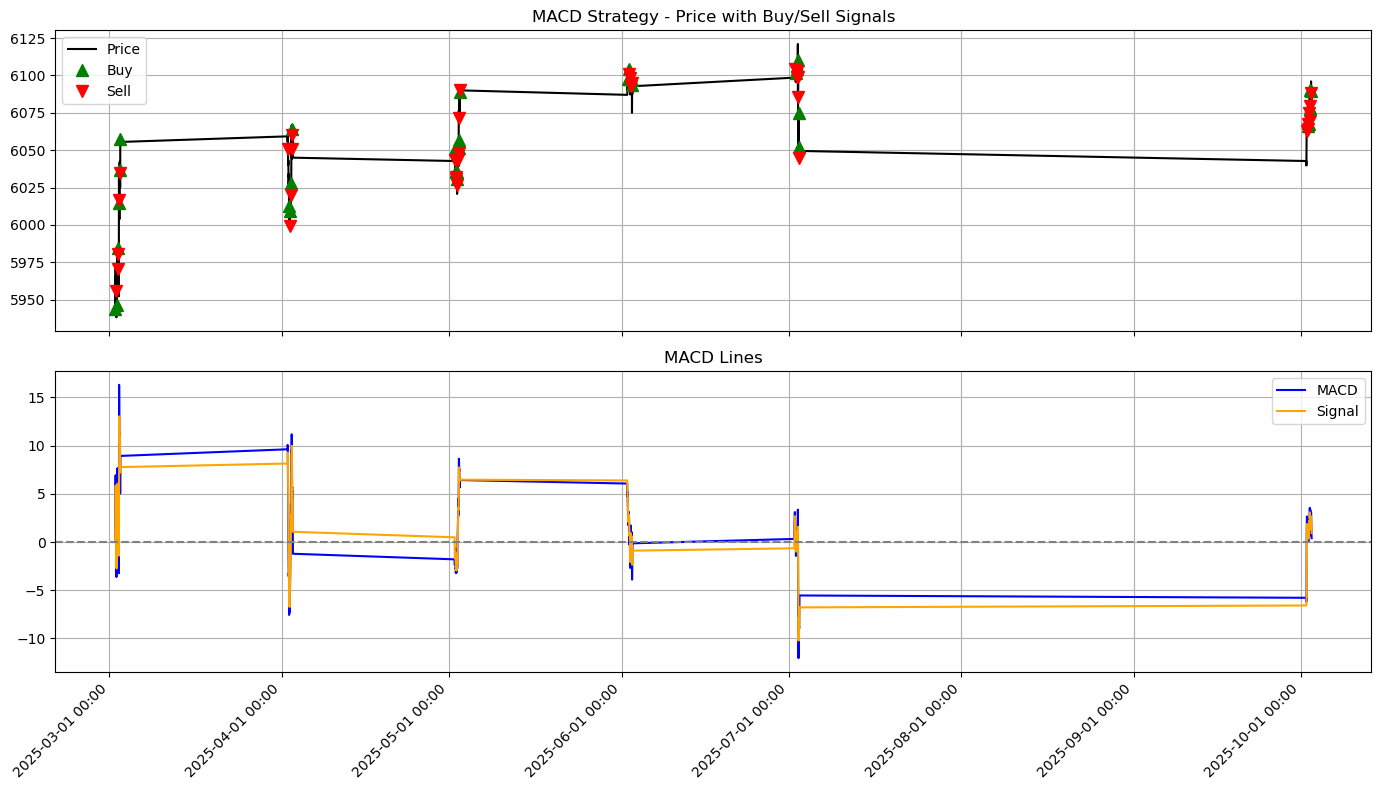

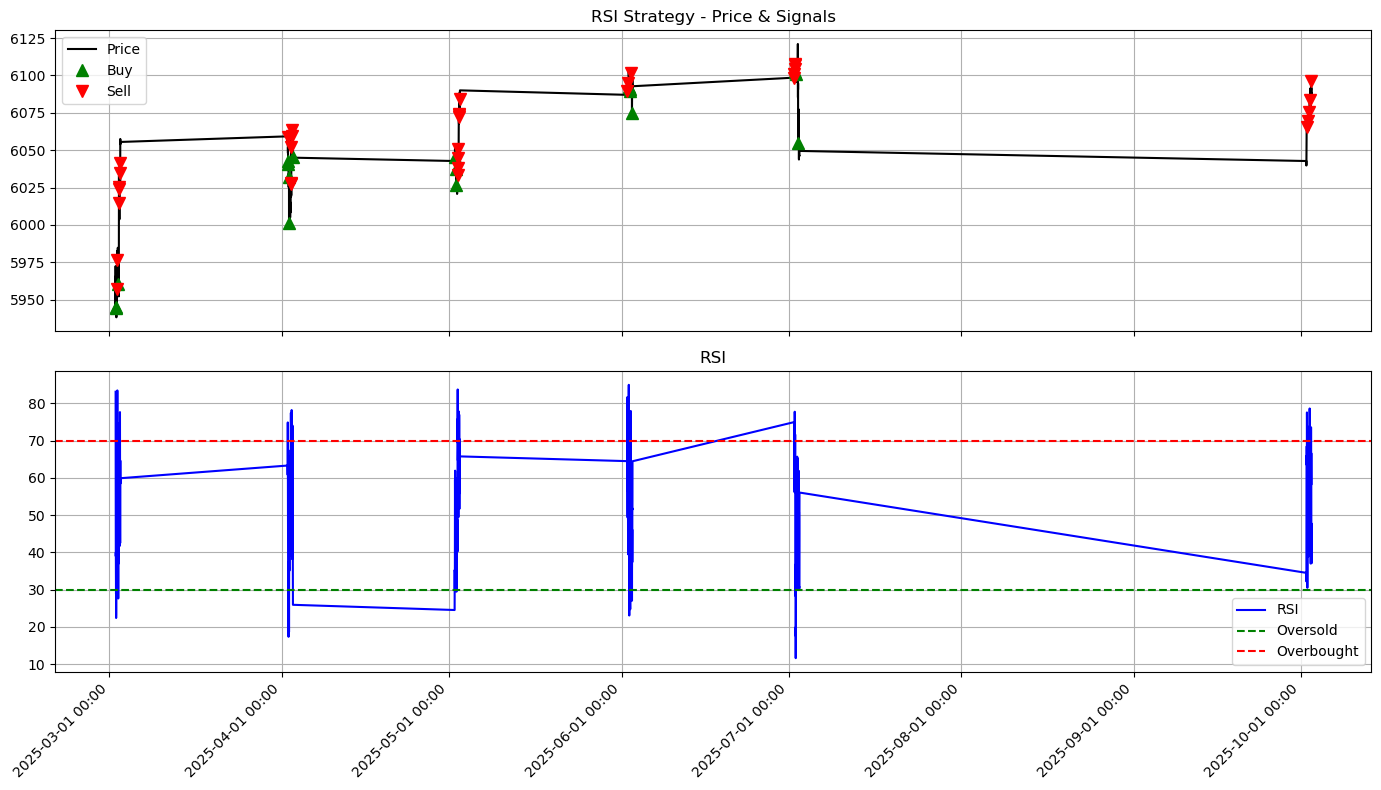

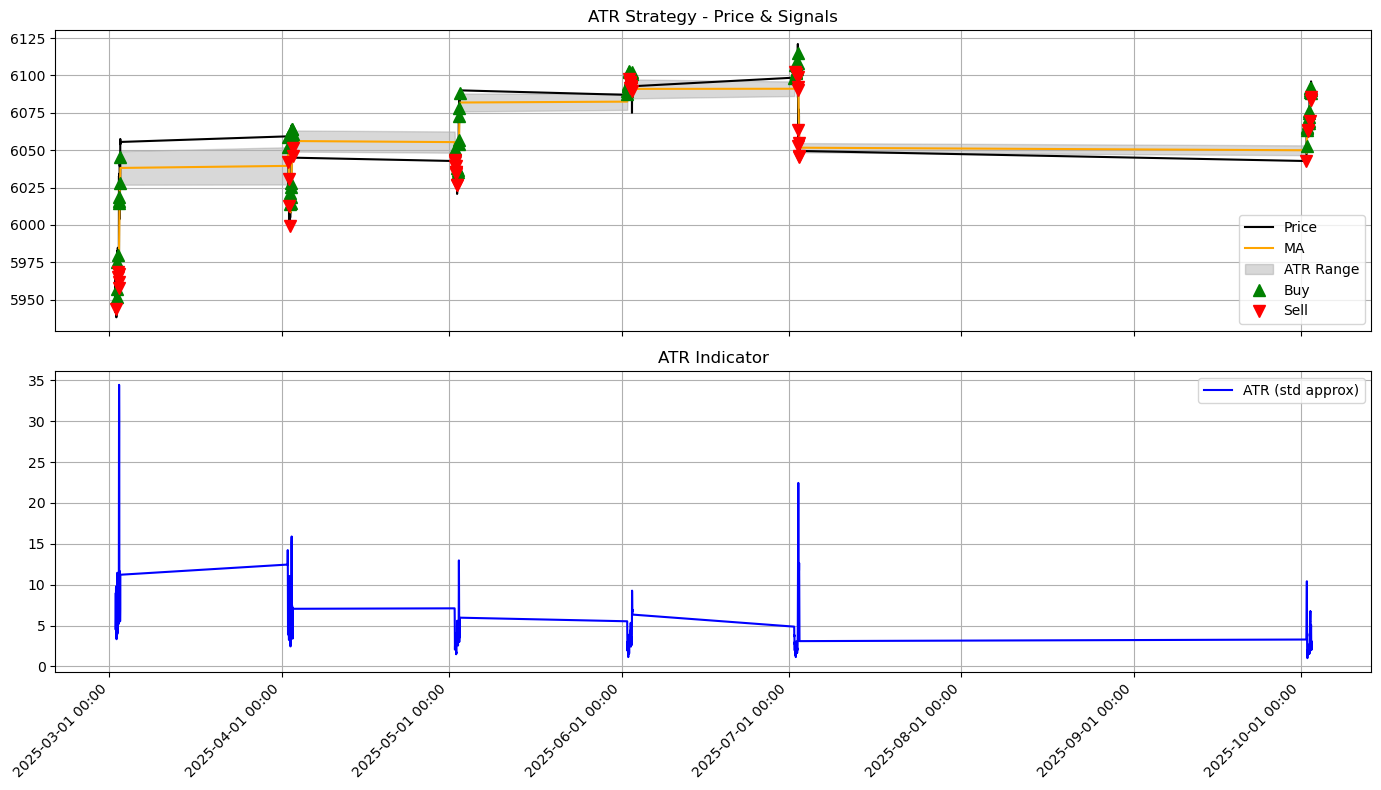

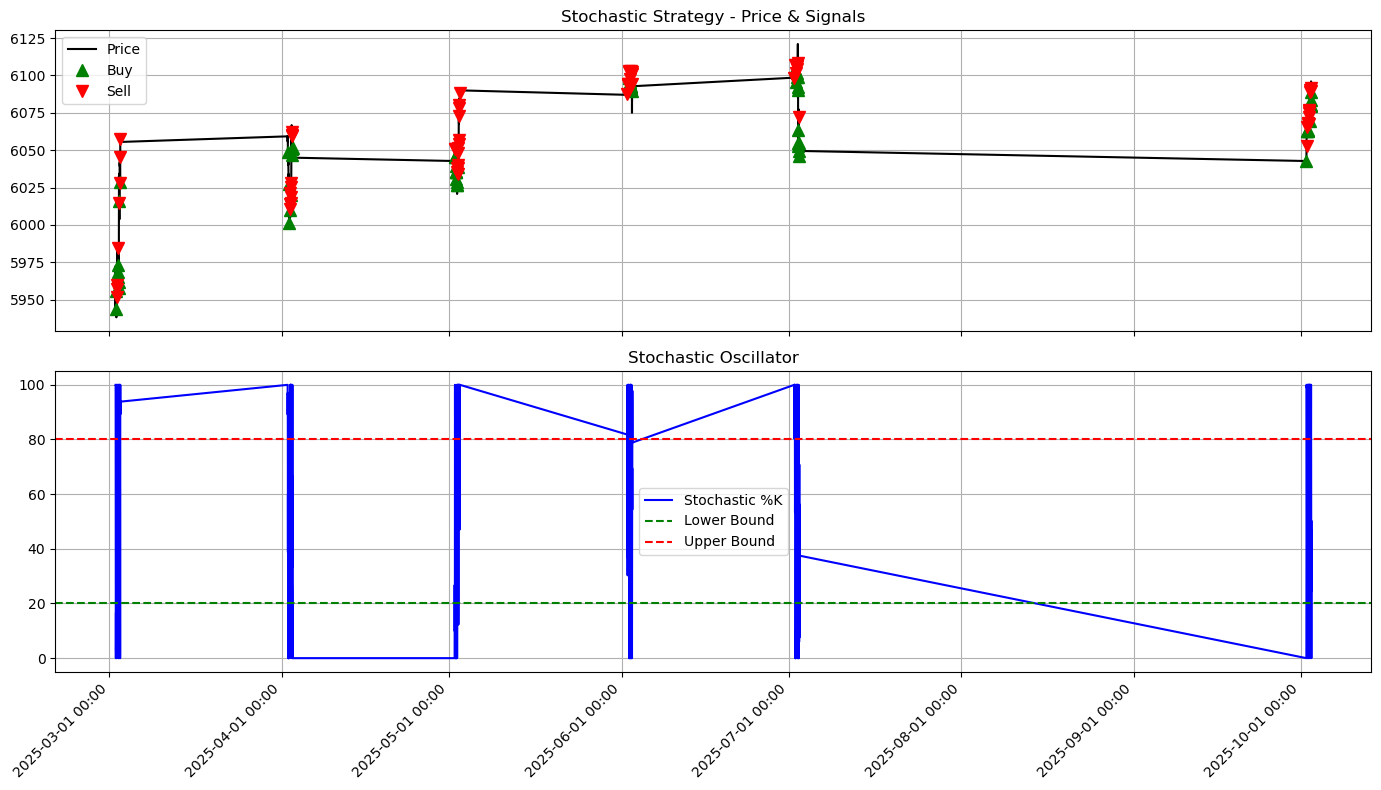

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============================================================================
# 1. LOAD DATA & CLEAN
# =============================================================================
file_path = "/Users/oscarolsen/Desktop/Algorithmic Trading/Algorithmic-Trading/Stor pik.csv"
df = pd.read_csv(file_path, sep=";", header=None)
df = df[[0, 1]]
df.columns = ["Date", "Price"]

# Clean up the "Price" column
df["Price"] = df["Price"].str.replace(",", ".").str.strip()
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Parse dates (format: dd/mm/yy HH.MM.SS)
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y %H.%M.%S", errors="coerce")

# Drop any rows with invalid data
df.dropna(inplace=True)

# Set Date as the index
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# If your dataset has duplicate timestamps, remove them:
df = df[~df.index.duplicated(keep="last")]

# Final Price series
prices = df["Price"]

# =============================================================================
# 2. COMMON FUNCTIONS
# =============================================================================
def buy_and_hold(prices, initial_cash=100_000):
    first_price = prices.iloc[0]
    units = initial_cash / first_price
    bh_series = prices * units
    bh_series.name = "BuyHold"
    return bh_series

def calculate_equity(prices, signals, initial_cash=100_000, stop_loss=0.05, take_profit=0.10, transaction_cost=0):
    """
    Enter a long position when signal == 1, exit if price hits stop-loss, 
    take-profit, or signal == -1. Returns an equity DataFrame with a single column 'Equity'.
    """
    # Remove duplicate indexes in signals too, just in case
    signals = signals[~signals.index.duplicated(keep="last")]

    position = 0.0
    cash = float(initial_cash)
    entry_price = 0.0
    equity_data = []

    # Ensure signals is in chronological order
    signals = signals.sort_index()

    for date, sig_val in signals.items():
        # If date isn't in prices, skip
        if date not in prices.index:
            continue

        price = prices.at[date]  # This will be a scalar now, after dedup

        # If no open position, check for a buy signal
        if position == 0 and sig_val == 1:
            position = cash / price
            entry_price = price
            cash = 0

        elif position > 0:
            # Evaluate stop-loss / take-profit
            stop = entry_price * (1 - stop_loss)
            limit = entry_price * (1 + take_profit)
            # If conditions are met OR we see a sell signal
            if price <= stop or price >= limit or sig_val == -1:
                trade_val = position * price
                cost = transaction_cost * trade_val
                cash = trade_val - cost
                position = 0

        # Calculate current equity
        equity = cash if position == 0 else position * price
        equity_data.append((date, equity))

    # Create a DataFrame
    eq_df = pd.DataFrame(equity_data, columns=["Date", "Equity"]).set_index("Date")
    # Fill forward any missing timestamps
    eq_df = eq_df.reindex(prices.index, method="ffill").dropna()
    return eq_df

# =============================================================================
# 3. MACD STRATEGY
# =============================================================================
def macd_strategy(prices, short=12, long=26, signal=9):
    ema_short = prices.ewm(span=short, adjust=False).mean()
    ema_long = prices.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()

    signals = pd.Series(0, index=prices.index)
    signals[macd_line > signal_line] = 1
    signals[macd_line < signal_line] = -1

    return signals, macd_line, signal_line

def visualize_macd(prices, macd_line, signal_line, signals):
    # Identify actual crossovers
    crossover_buy = (signals == 1) & (signals.shift(1) != 1)
    crossover_sell = (signals == -1) & (signals.shift(1) != -1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)

    ax1.plot(prices, label='Price', color='black')
    ax1.plot(prices[crossover_buy], '^', color='green', markersize=8, linestyle='None', label='Buy')
    ax1.plot(prices[crossover_sell], 'v', color='red', markersize=8, linestyle='None', label='Sell')
    ax1.set_title("MACD Strategy - Price with Buy/Sell Signals")
    ax1.legend()
    ax1.grid()

    ax2.plot(macd_line, label='MACD', color='blue')
    ax2.plot(signal_line, label='Signal', color='orange')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_title("MACD Lines")
    ax2.legend()
    ax2.grid()

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. RSI STRATEGY
# =============================================================================
def rsi_strategy(prices, window=14, oversold=30, overbought=70):
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)

    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    signals = pd.Series(0, index=prices.index)
    # Buy when crossing upward oversold
    signals[(rsi < oversold) & (rsi.shift(1) >= oversold)] = 1
    # Sell when crossing downward overbought
    signals[(rsi > overbought) & (rsi.shift(1) <= overbought)] = -1

    return signals, rsi

def visualize_rsi(prices, rsi, signals, oversold=30, overbought=70):
    crossover_buy = (signals == 1) & (signals.shift(1) != 1)
    crossover_sell = (signals == -1) & (signals.shift(1) != -1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)

    ax1.plot(prices, color='black', label='Price')
    ax1.plot(prices[crossover_buy], '^', color='green', markersize=8, linestyle='None', label='Buy')
    ax1.plot(prices[crossover_sell], 'v', color='red', markersize=8, linestyle='None', label='Sell')
    ax1.set_title("RSI Strategy - Price & Signals")
    ax1.legend()
    ax1.grid()

    ax2.plot(rsi, label='RSI', color='blue')
    ax2.axhline(oversold, color='green', linestyle='--', label='Oversold')
    ax2.axhline(overbought, color='red', linestyle='--', label='Overbought')
    ax2.legend()
    ax2.set_title("RSI")
    ax2.grid()

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. ATR STRATEGY
# =============================================================================
def atr_indicator(prices, window=14):
    # Approximate ATR with rolling std, since we only have close prices
    return prices.rolling(window).std()

def atr_strategy(prices, window=14, ma_window=20, k=1):
    ma = prices.rolling(ma_window).mean()
    atr_vals = atr_indicator(prices, window)
    signals = pd.Series(0, index=prices.index)

    # Buy if above MA + k*ATR, sell if below MA - k*ATR
    signals[prices > ma + k * atr_vals] = 1
    signals[prices < ma - k * atr_vals] = -1

    return signals, ma, atr_vals

def visualize_atr(prices, ma, atr_vals, signals):
    buy_pts = (signals == 1) & (signals.shift(1) != 1)
    sell_pts = (signals == -1) & (signals.shift(1) != -1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)

    ax1.plot(prices, color='black', label='Price')
    ax1.plot(ma, color='orange', label='MA')
    ax1.fill_between(prices.index, ma - atr_vals, ma + atr_vals, color='grey', alpha=0.3, label='ATR Range')
    ax1.plot(prices[buy_pts], '^', color='green', markersize=8, linestyle='None', label='Buy')
    ax1.plot(prices[sell_pts], 'v', color='red', markersize=8, linestyle='None', label='Sell')
    ax1.set_title("ATR Strategy - Price & Signals")
    ax1.legend()
    ax1.grid()

    ax2.plot(atr_vals, color='blue', label='ATR (std approx)')
    ax2.set_title("ATR Indicator")
    ax2.legend()
    ax2.grid()

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 6. STOCHASTIC STRATEGY
# =============================================================================
def stochastic_indicator(prices, window=14):
    lowest_low = prices.rolling(window).min()
    highest_high = prices.rolling(window).max()
    return (prices - lowest_low) / (highest_high - lowest_low) * 100

def stochastic_strategy(prices, window=14, lower_bound=20, upper_bound=80):
    stoch = stochastic_indicator(prices, window=window)
    signals = pd.Series(0, index=prices.index)

    # Buy when crossing below lower_bound, Sell when crossing above upper_bound
    signals[(stoch < lower_bound) & (stoch.shift(1) >= lower_bound)] = 1
    signals[(stoch > upper_bound) & (stoch.shift(1) <= upper_bound)] = -1

    return signals, stoch

def visualize_stochastic(prices, stoch, signals, lower_bound=20, upper_bound=80):
    buy_pts = (signals == 1) & (signals.shift(1) != 1)
    sell_pts = (signals == -1) & (signals.shift(1) != -1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)

    ax1.plot(prices, color='black', label='Price')
    ax1.plot(prices[buy_pts], '^', color='green', markersize=8, linestyle='None', label='Buy')
    ax1.plot(prices[sell_pts], 'v', color='red', markersize=8, linestyle='None', label='Sell')
    ax1.set_title("Stochastic Strategy - Price & Signals")
    ax1.legend()
    ax1.grid()

    ax2.plot(stoch, color='blue', label='Stochastic %K')
    ax2.axhline(lower_bound, color='green', linestyle='--', label='Lower Bound')
    ax2.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound')
    ax2.set_title("Stochastic Oscillator")
    ax2.legend()
    ax2.grid()

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. RUN STRATEGIES & COMPARE
# =============================================================================
if __name__ == "__main__":
    # Macd
    macd_signals, macd_line, macd_sigline = macd_strategy(prices)
    macd_equity = calculate_equity(prices, macd_signals)

    # Rsi
    rsi_signals, rsi_vals = rsi_strategy(prices)
    rsi_equity = calculate_equity(prices, rsi_signals)

    # Atr
    atr_signals, atr_ma, atr_std = atr_strategy(prices)
    atr_equity = calculate_equity(prices, atr_signals)

    # Stochastic
    stoch_signals, stoch_vals = stochastic_strategy(prices)
    stoch_equity = calculate_equity(prices, stoch_signals)

    # Buy & hold
    buyhold = buy_and_hold(prices)

    # Combine results
    combined = pd.DataFrame({
        "MACD": macd_equity["Equity"],
        "RSI": rsi_equity["Equity"],
        "ATR": atr_equity["Equity"],
        "Stoch": stoch_equity["Equity"],
        "BuyHold": buyhold
    }).dropna()

    # Show last 5
    print("\n== STRATEGY COMPARISON (LAST 5 ROWS) ==\n")
    print(combined.tail())

    # Plot smoothed equity curves
    smoothing_window = 20
    combined_smooth = combined.rolling(smoothing_window, min_periods=1).mean()

    plt.figure(figsize=(14,8))
    for col in combined_smooth.columns:
        plt.plot(combined_smooth.index, combined_smooth[col], label=col)
    plt.title("Smoothed Equity Curves: Strategies vs. Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

    # Individual strategy plots (optional)
    visualize_macd(prices, macd_line, macd_sigline, macd_signals)
    visualize_rsi(prices, rsi_vals, rsi_signals)
    visualize_atr(prices, atr_ma, atr_std, atr_signals)
    visualize_stochastic(prices, stoch_vals, stoch_signals)


"\nSummary / Comparison:\n\nWe implemented four different strategies on the same dataset:\n\n  - MACD (fast EMA = 12, slow EMA = 26, signal = 9)\n  - RSI (window=14, oversold=30, overbought=70)\n  - ATR-based strategy (uses a moving average ± k*ATR to trigger buy/sell)\n  - Stochastic oscillator (window=14, bounds=20/80)\n\nWe used:\n  - Initial cash = 100,000\n  - 5% stop-loss\n  - 10% take-profit\n  - 0 transaction cost\n\nWe compared each strategy's equity curve against a simple Buy & Hold position.\nThe final 'comparison_df' DataFrame shows how each strategy performed over time.\nPlots for each strategy include the price chart, the indicator, and buy/sell markers.\n\nCheck the final rows of 'comparison_df' or plot them to see which strategy\noutperformed the others and how they stack up against Buy & Hold.\n"

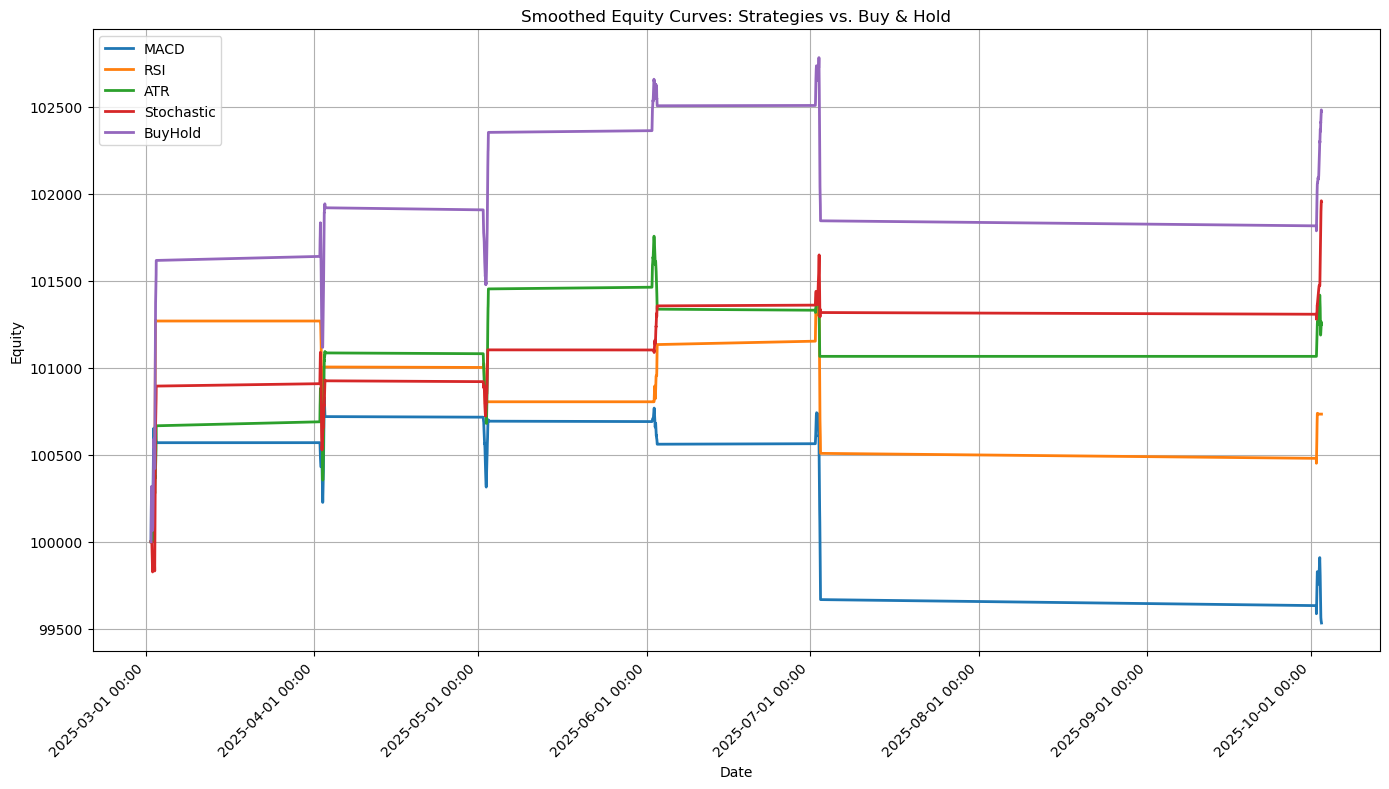

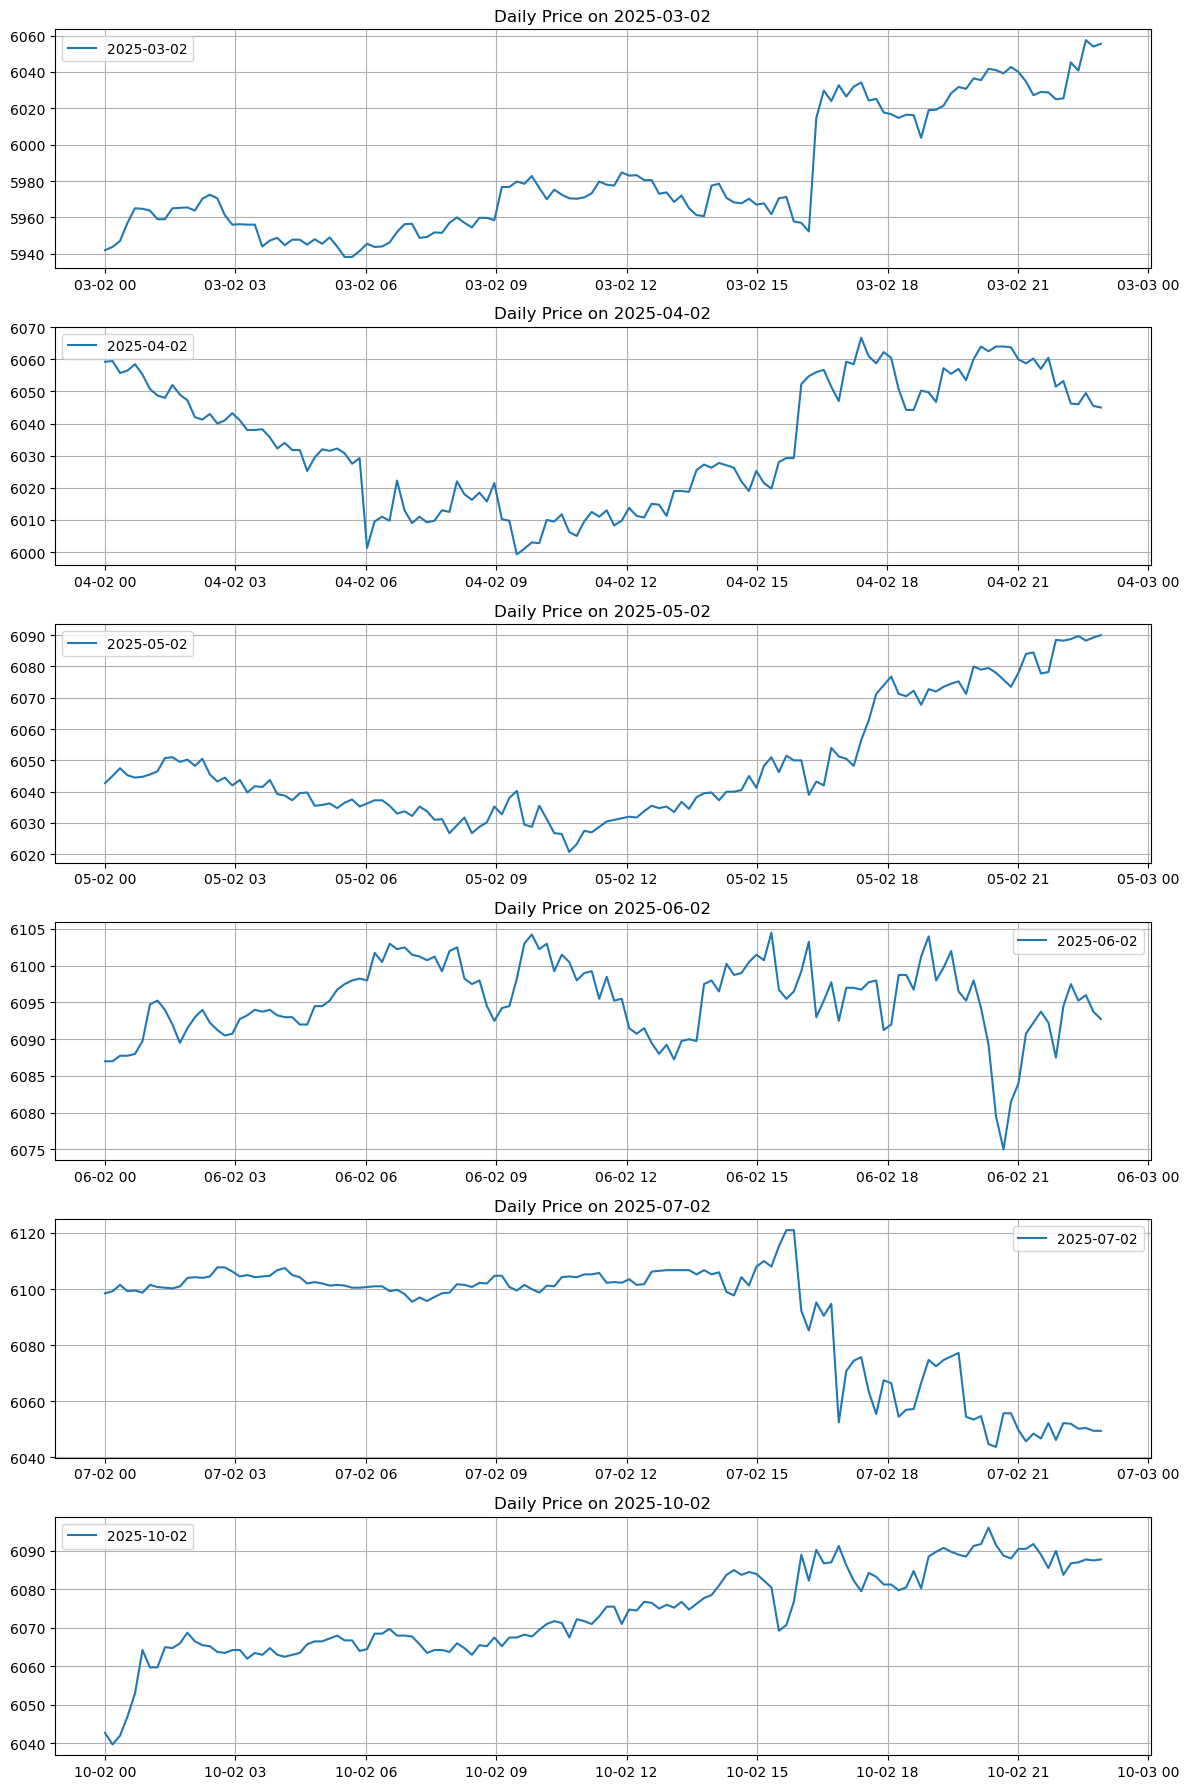

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============================================================================
# 1. LOAD DATA & CLEAN
# =============================================================================
file_path = "/Users/oscarolsen/Desktop/Algorithmic Trading/Algorithmic-Trading/Stor pik.csv"
df = pd.read_csv(file_path, sep=";", header=None)
df = df[[0, 1]]
df.columns = ["Date", "Price"]

# Clean Price: replace comma with dot, then convert to numeric
df["Price"] = df["Price"].str.replace(",", ".").str.strip()
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Parse Date (format: dd/mm/yy HH.MM.SS)
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y %H.%M.%S", errors="coerce")
df.dropna(inplace=True)
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# Remove duplicate timestamps (if any)
df = df[~df.index.duplicated(keep="last")]
prices = df["Price"]

# =============================================================================
# 2. COMMON FUNCTIONS
# =============================================================================
def buy_and_hold(prices, initial_cash=100_000):
    first_price = prices.iloc[0]
    units = initial_cash / first_price
    bh_series = prices * units
    bh_series.name = "BuyHold"
    return bh_series

def continuous_equity(prices, signals, initial_cash=100_000, stop_loss=0.05, take_profit=0.10, transaction_cost=0):
    """
    Updates equity at every price bar.
    If in a position, equity changes with the mark-to-market price at every timestamp.
    """
    # Ensure we have a signal for every price bar
    signals = signals.reindex(prices.index, method="ffill").fillna(0)
    
    position = 0.0
    cash = float(initial_cash)
    entry_price = 0.0
    equity_list = []
    
    for i, (date, price) in enumerate(prices.items()):
        current_signal = signals.iloc[i]
        # Enter a position if no current position and there's a buy signal
        if position == 0 and current_signal == 1:
            position = cash / price
            entry_price = price
            cash = 0
        # If in a position, check for stop-loss, take-profit, or exit signal
        elif position > 0:
            stop = entry_price * (1 - stop_loss)
            limit = entry_price * (1 + take_profit)
            if price <= stop or price >= limit or current_signal == -1:
                trade_value = position * price
                cost = transaction_cost * trade_value
                cash = trade_value - cost
                position = 0
        # Mark-to-market: update equity at every bar
        equity = cash if position == 0 else position * price
        equity_list.append((date, equity))
    
    eq_df = pd.DataFrame(equity_list, columns=["Date", "Equity"]).set_index("Date")
    return eq_df

# =============================================================================
# 3. STRATEGY FUNCTIONS
# =============================================================================
# --- MACD ---
def macd_strategy(prices, short=12, long=26, signal=9):
    ema_short = prices.ewm(span=short, adjust=False).mean()
    ema_long = prices.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    signals = pd.Series(0, index=prices.index)
    signals[macd_line > signal_line] = 1
    signals[macd_line < signal_line] = -1
    return signals, macd_line, signal_line

# --- RSI ---
def rsi_strategy(prices, window=14, oversold=30, overbought=70):
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    signals = pd.Series(0, index=prices.index)
    signals[(rsi < oversold) & (rsi.shift(1) >= oversold)] = 1
    signals[(rsi > overbought) & (rsi.shift(1) <= overbought)] = -1
    return signals, rsi

# --- ATR ---
def atr_indicator(prices, window=14):
    # Use rolling standard deviation as an approximation for ATR (only close prices available)
    return prices.rolling(window).std()

def atr_strategy(prices, window=14, ma_window=20, k=1):
    ma = prices.rolling(window=ma_window).mean()
    atr_vals = atr_indicator(prices, window)
    signals = pd.Series(0, index=prices.index)
    signals[prices > ma + k * atr_vals] = 1
    signals[prices < ma - k * atr_vals] = -1
    return signals, ma, atr_vals

# --- Stochastic ---
def stochastic_indicator(prices, window=14):
    lowest_low = prices.rolling(window).min()
    highest_high = prices.rolling(window).max()
    stoch = (prices - lowest_low) / (highest_high - lowest_low) * 100
    return stoch

def stochastic_strategy(prices, window=14, lower_bound=20, upper_bound=80):
    stoch = stochastic_indicator(prices, window)
    signals = pd.Series(0, index=prices.index)
    signals[(stoch < lower_bound) & (stoch.shift(1) >= lower_bound)] = 1
    signals[(stoch > upper_bound) & (stoch.shift(1) <= upper_bound)] = -1
    return signals, stoch

# =============================================================================
# 4. VISUALIZATION FUNCTIONS
# =============================================================================
def visualize_equity_comparison(equity_dict, smoothing_window=20):
    """Plots a single, smoothed equity curve for each strategy vs. Buy & Hold."""
    combined = pd.DataFrame(equity_dict).dropna()
    combined_smooth = combined.rolling(smoothing_window, min_periods=1).mean()
    plt.figure(figsize=(14,8))
    for col in combined_smooth.columns:
        plt.plot(combined_smooth.index, combined_smooth[col], label=col, linewidth=2)
    plt.title("Smoothed Equity Curves: Strategies vs. Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

def visualize_daily_subplots(df, col, title):
    """
    Splits the data into daily subsets and plots each day in a separate subplot.
    This reduces overcrowding when multiple days are in the same graph.
    """
    # Convert the NumPy array of dates into a Pandas Series to use .unique()
    unique_days = sorted(pd.Series(df.index.date).unique())
    n_days = len(unique_days)
    fig, axes = plt.subplots(nrows=n_days, ncols=1, figsize=(12, 3 * n_days), sharex=False)
    if n_days == 1:
        axes = [axes]
    for ax, day in zip(axes, unique_days):
        mask = (df.index.date == day)
        ax.plot(df.loc[mask].index, df.loc[mask, col], label=str(day))
        ax.set_title(f"{title} on {day}")
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. RUN STRATEGIES & SIMULATE EQUITY
# =============================================================================
if __name__ == "__main__":
    initial_cash = 100_000

    # MACD Strategy
    macd_signals, macd_line, macd_sigline = macd_strategy(prices)
    macd_eq = continuous_equity(prices, macd_signals, initial_cash=initial_cash)

    # RSI Strategy
    rsi_signals, rsi_vals = rsi_strategy(prices)
    rsi_eq = continuous_equity(prices, rsi_signals, initial_cash=initial_cash)

    # ATR Strategy
    atr_signals, atr_ma, atr_vals = atr_strategy(prices)
    atr_eq = continuous_equity(prices, atr_signals, initial_cash=initial_cash)

    # Stochastic Strategy
    stoch_signals, stoch_vals = stochastic_strategy(prices)
    stoch_eq = continuous_equity(prices, stoch_signals, initial_cash=initial_cash)

    # Buy & Hold Benchmark
    bh_series = buy_and_hold(prices, initial_cash=initial_cash)
    bh_eq = pd.DataFrame({"BuyHold": bh_series})

    # Combine equity curves into a single DataFrame
    equity_dict = {
        "MACD": macd_eq["Equity"],
        "RSI": rsi_eq["Equity"],
        "ATR": atr_eq["Equity"],
        "Stochastic": stoch_eq["Equity"],
        "BuyHold": bh_eq["BuyHold"]
    }

    # Plot the combined smoothed equity curves
    visualize_equity_comparison(equity_dict, smoothing_window=20)

    # OPTIONAL: Plot daily subplots of Price to see daily signals clearly
    visualize_daily_subplots(df, "Price", "Daily Price")


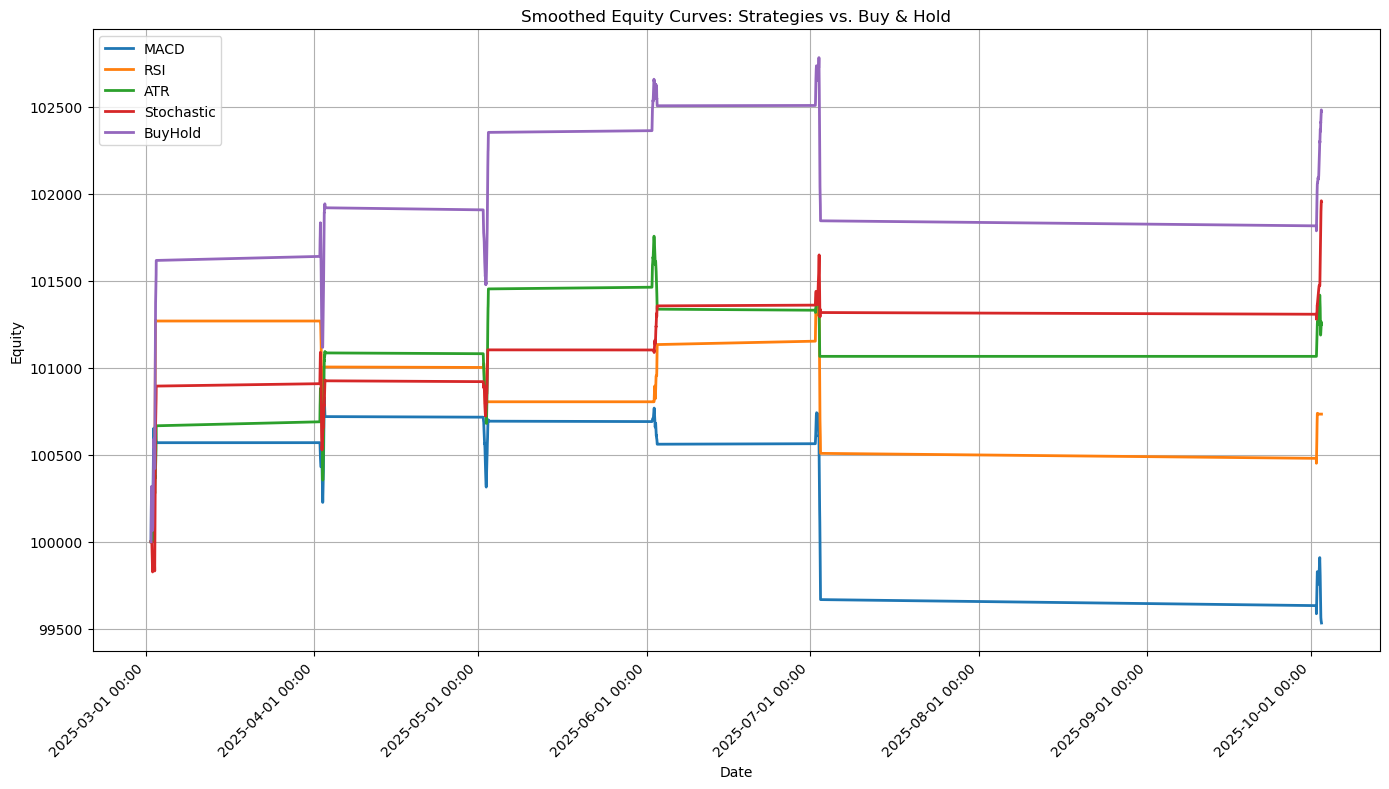

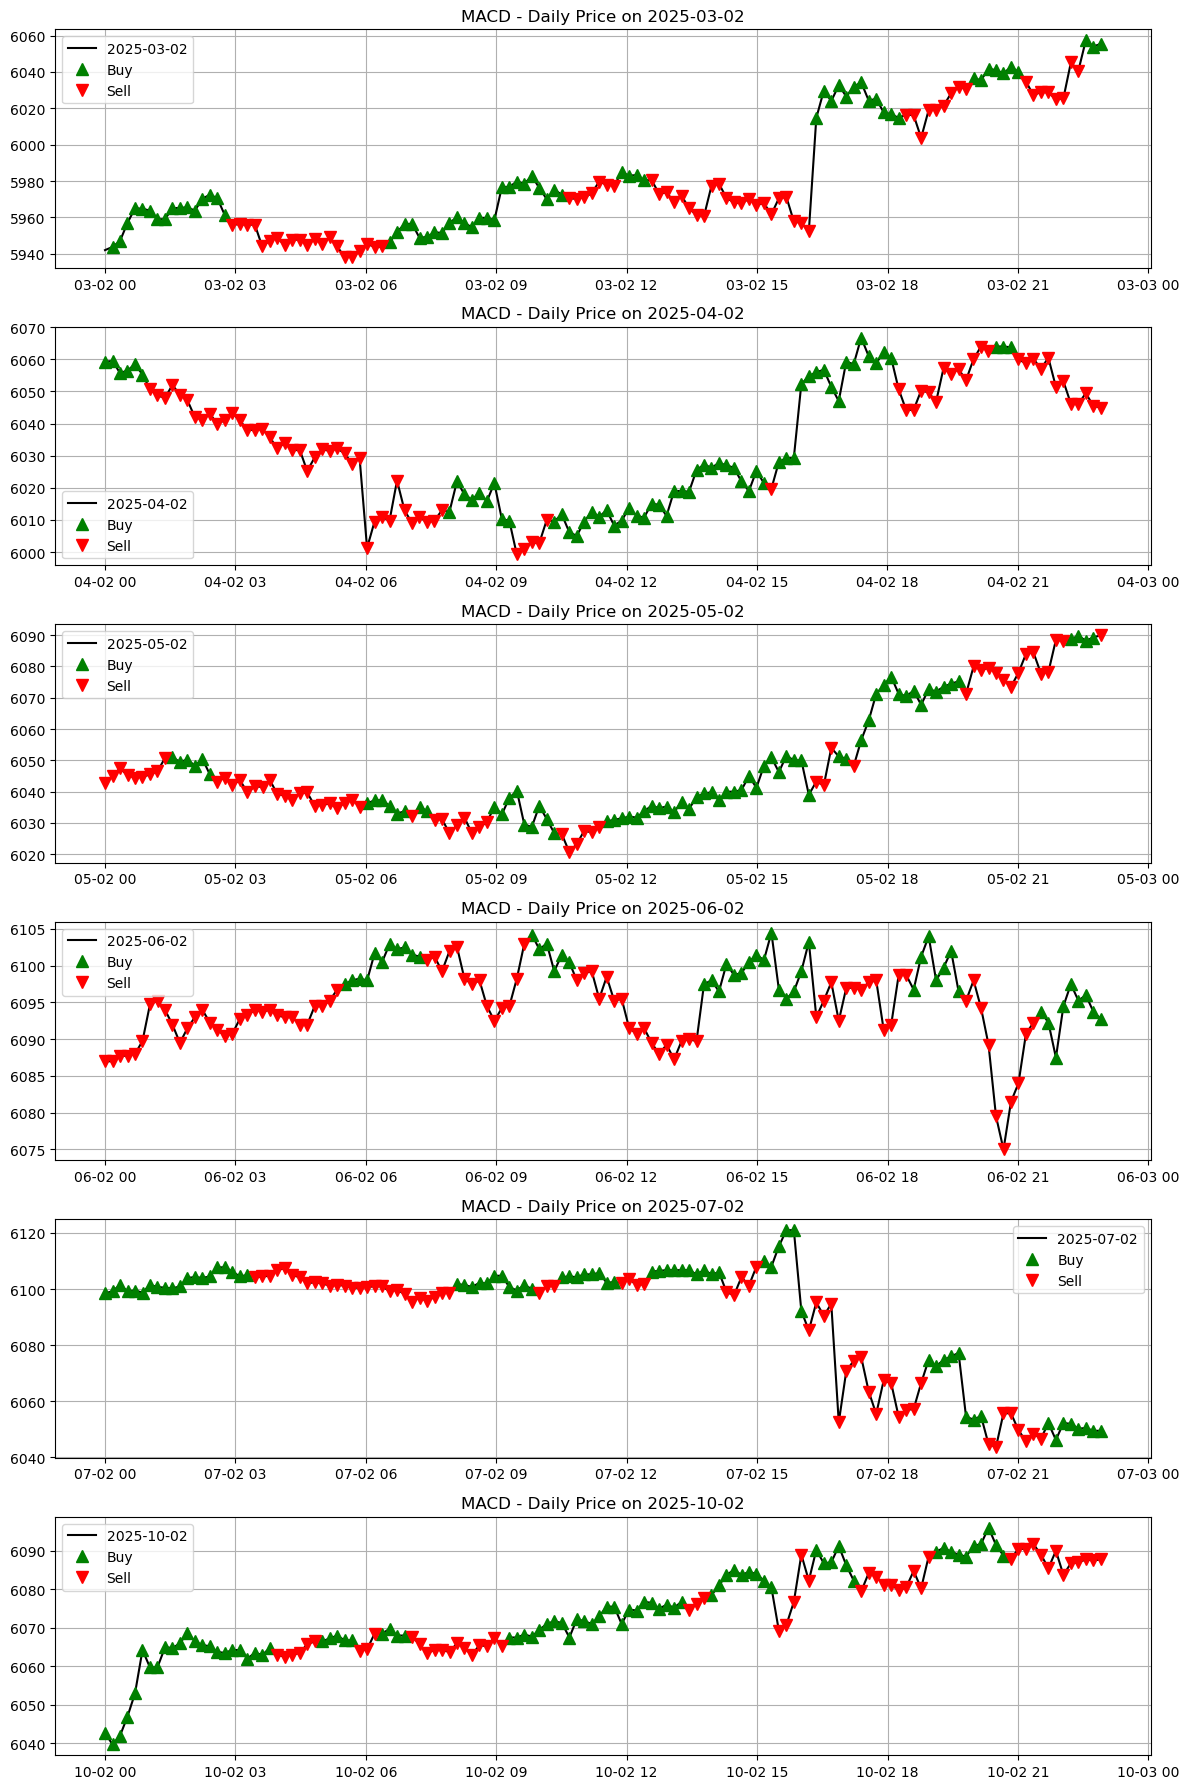

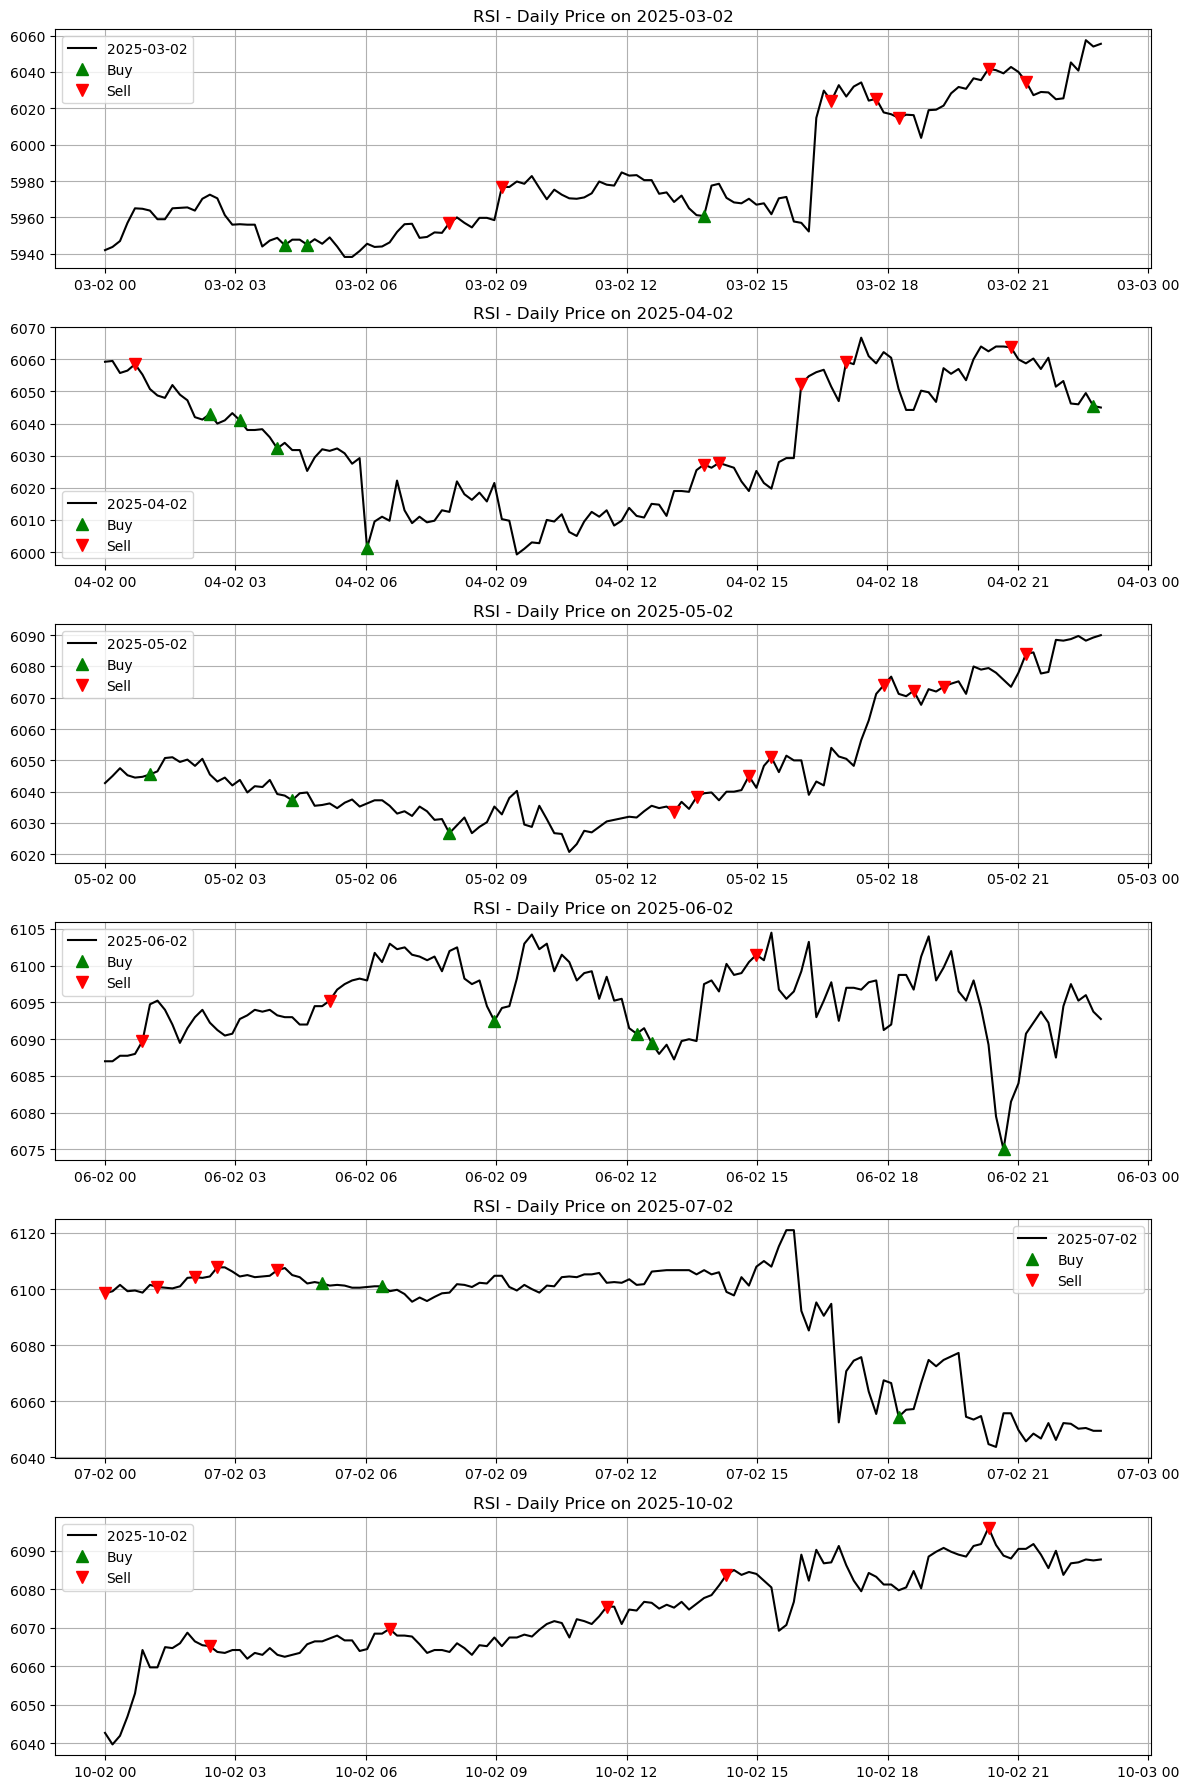

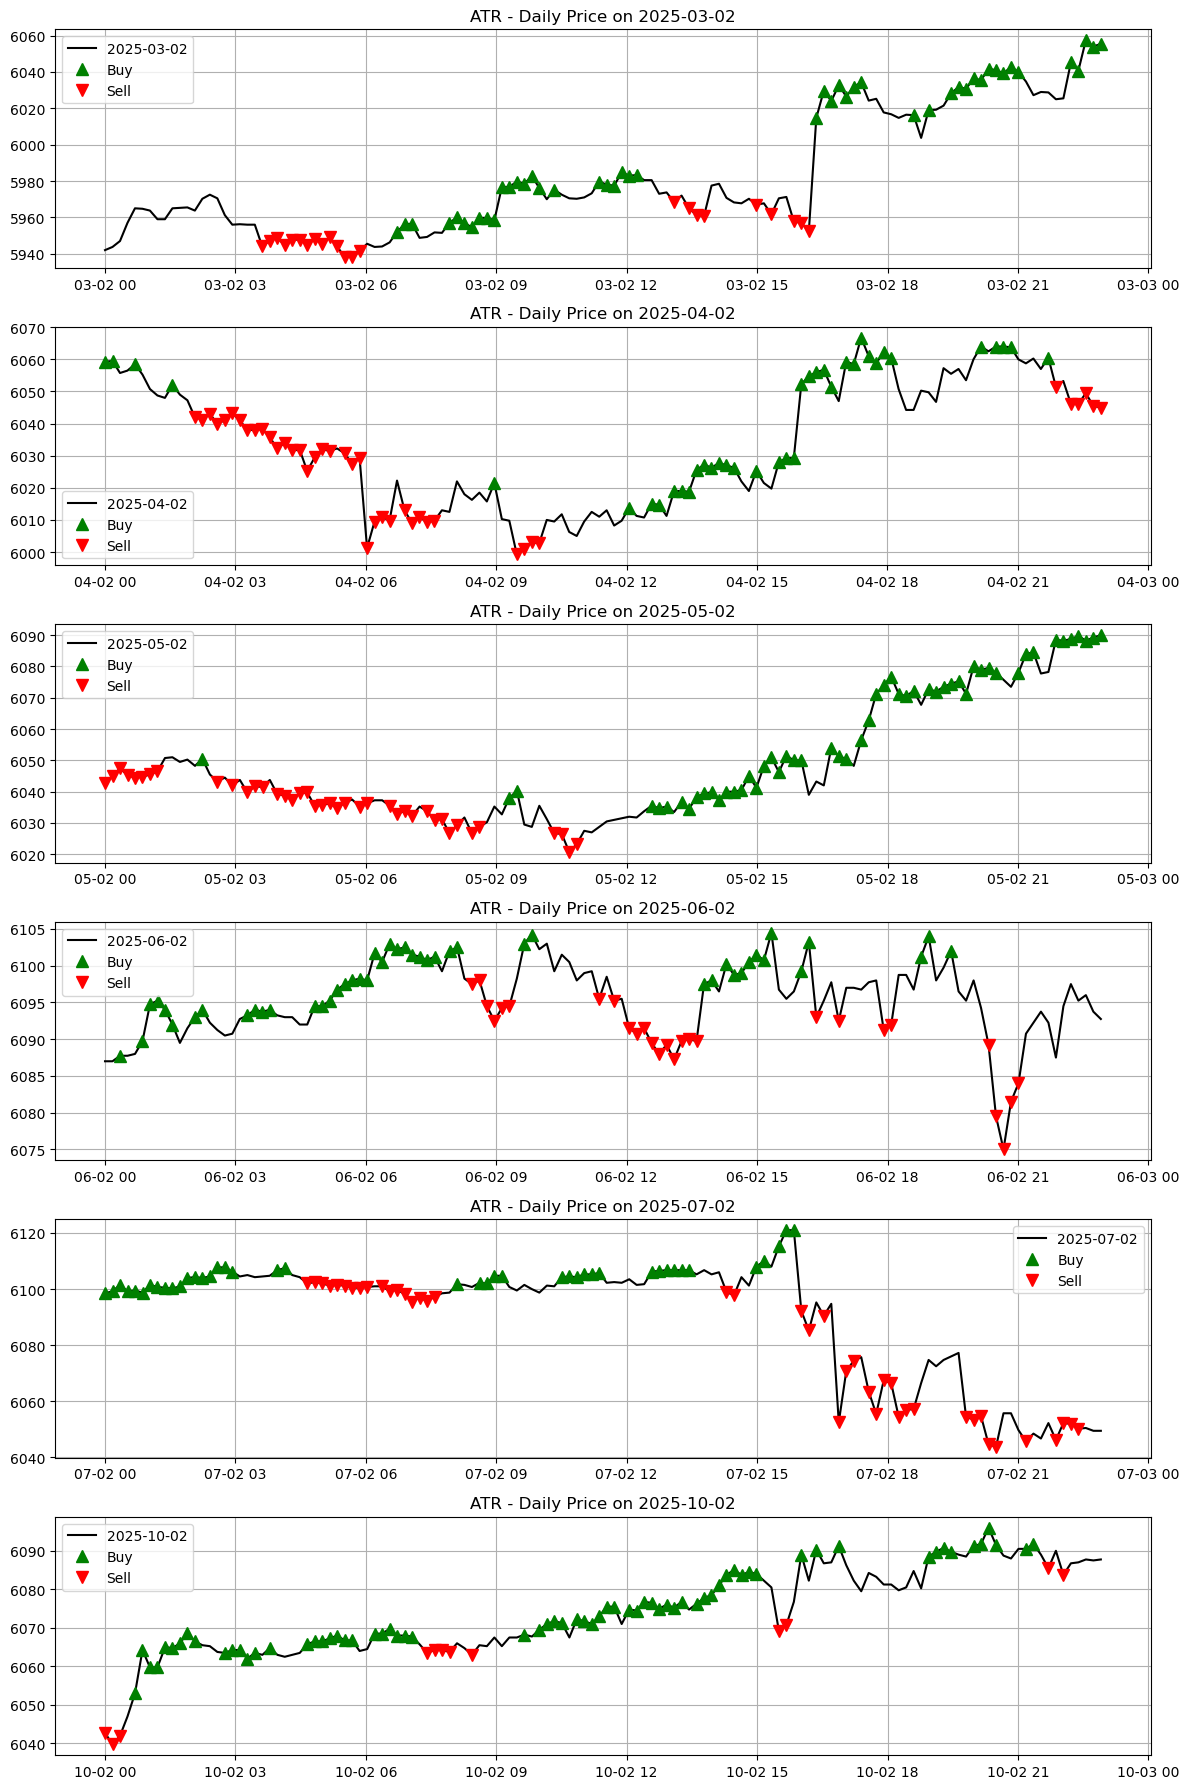

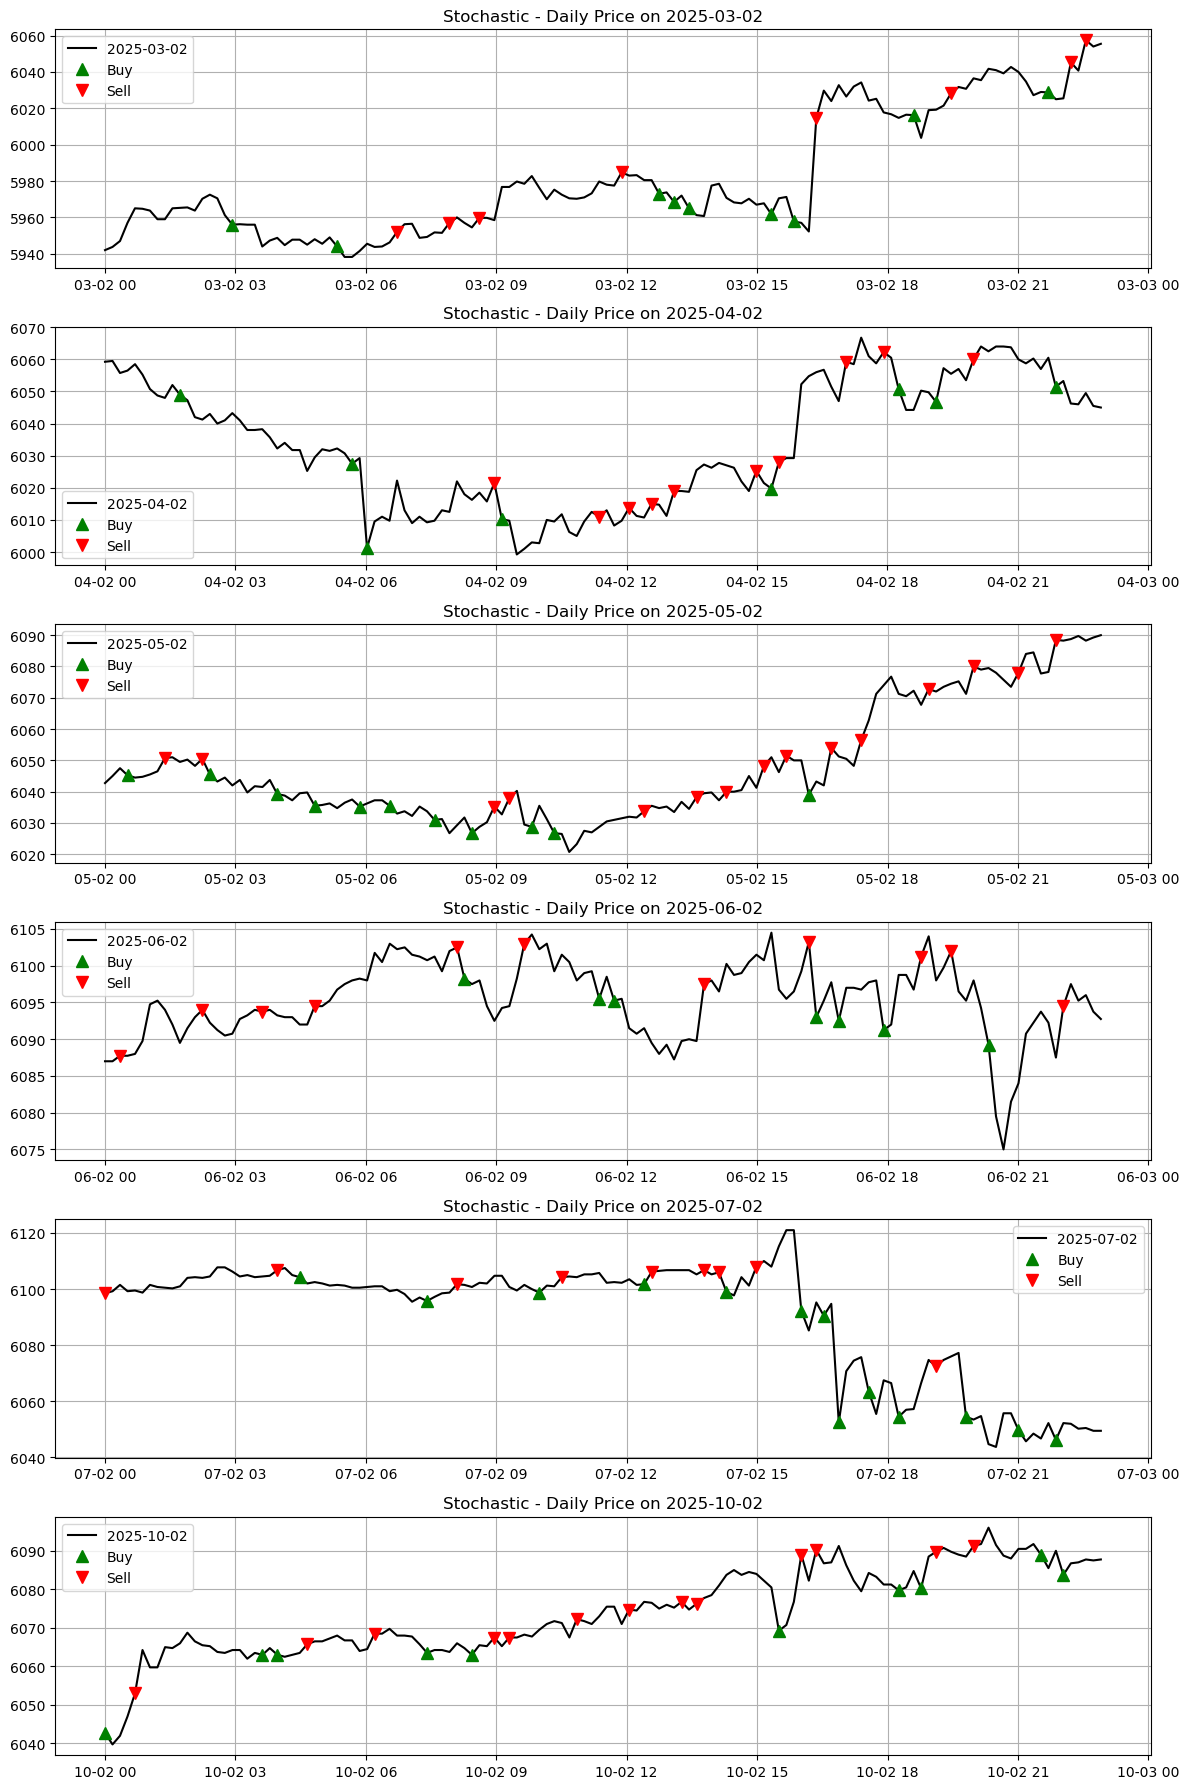

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============================================================================
# 1. LOAD DATA & CLEAN
# =============================================================================
file_path = "/Users/oscarolsen/Desktop/Algorithmic Trading/Algorithmic-Trading/Stor pik.csv"
df = pd.read_csv(file_path, sep=";", header=None)
df = df[[0, 1]]
df.columns = ["Date", "Price"]

# Clean Price: replace comma with dot, then convert to numeric
df["Price"] = df["Price"].str.replace(",", ".").str.strip()
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Parse Date (format: dd/mm/yy HH.MM.SS)
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y %H.%M.%S", errors="coerce")
df.dropna(inplace=True)
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# Remove any duplicate timestamps
df = df[~df.index.duplicated(keep="last")]
prices = df["Price"]

# =============================================================================
# 2. COMMON FUNCTIONS
# =============================================================================
def buy_and_hold(prices, initial_cash=100_000):
    first_price = prices.iloc[0]
    units = initial_cash / first_price
    bh_series = prices * units
    bh_series.name = "BuyHold"
    return bh_series

def continuous_equity(prices, signals, 
                      initial_cash=100_000, stop_loss=0.05, take_profit=0.10, 
                      transaction_cost=0):
    """
    Updates equity at every price bar. If in a position, 
    equity changes each bar with the mark-to-market price.
    """
    # Make sure signals exists for every timestamp in prices
    signals = signals.reindex(prices.index, method="ffill").fillna(0)
    
    position = 0.0
    cash = float(initial_cash)
    entry_price = 0.0
    
    equity_list = []
    for i, (date, price) in enumerate(prices.items()):
        current_signal = signals.iloc[i]
        
        # Enter position if no position and signal is 1
        if position == 0 and current_signal == 1:
            position = cash / price
            entry_price = price
            cash = 0
        # If in a position, check stop-loss, take-profit, or sell signal
        elif position > 0:
            stop = entry_price * (1 - stop_loss)
            limit = entry_price * (1 + take_profit)
            if price <= stop or price >= limit or current_signal == -1:
                trade_val = position * price
                cost = transaction_cost * trade_val
                cash = trade_val - cost
                position = 0
        
        # Mark-to-market
        equity = cash if position == 0 else position * price
        equity_list.append((date, equity))
    
    eq_df = pd.DataFrame(equity_list, columns=["Date", "Equity"]).set_index("Date")
    return eq_df

# =============================================================================
# 3. STRATEGY FUNCTIONS
# =============================================================================
# --- MACD ---
def macd_strategy(prices, short=12, long=26, signal=9):
    ema_short = prices.ewm(span=short, adjust=False).mean()
    ema_long = prices.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    signals = pd.Series(0, index=prices.index)
    signals[macd_line > signal_line] = 1
    signals[macd_line < signal_line] = -1
    return signals, macd_line, signal_line

# --- RSI ---
def rsi_strategy(prices, window=14, oversold=30, overbought=70):
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    signals = pd.Series(0, index=prices.index)
    signals[(rsi < oversold) & (rsi.shift(1) >= oversold)] = 1
    signals[(rsi > overbought) & (rsi.shift(1) <= overbought)] = -1
    return signals, rsi

# --- ATR ---
def atr_indicator(prices, window=14):
    return prices.rolling(window).std()  # approximate ATR

def atr_strategy(prices, window=14, ma_window=20, k=1):
    ma = prices.rolling(window=ma_window).mean()
    atr_vals = atr_indicator(prices, window)
    signals = pd.Series(0, index=prices.index)
    signals[prices > ma + k * atr_vals] = 1
    signals[prices < ma - k * atr_vals] = -1
    return signals, ma, atr_vals

# --- Stochastic ---
def stochastic_indicator(prices, window=14):
    lowest_low = prices.rolling(window).min()
    highest_high = prices.rolling(window).max()
    stoch = (prices - lowest_low) / (highest_high - lowest_low) * 100
    return stoch

def stochastic_strategy(prices, window=14, lower_bound=20, upper_bound=80):
    stoch = stochastic_indicator(prices, window)
    signals = pd.Series(0, index=prices.index)
    signals[(stoch < lower_bound) & (stoch.shift(1) >= lower_bound)] = 1
    signals[(stoch > upper_bound) & (stoch.shift(1) <= upper_bound)] = -1
    return signals, stoch

# =============================================================================
# 4. VISUALIZATION
# =============================================================================
def visualize_equity_comparison(equity_dict, smoothing_window=20):
    """Plots a single, smoothed equity curve for each strategy vs. Buy & Hold."""
    combined = pd.DataFrame(equity_dict).dropna()
    combined_smooth = combined.rolling(smoothing_window, min_periods=1).mean()
    
    plt.figure(figsize=(14,8))
    for col in combined_smooth.columns:
        plt.plot(combined_smooth.index, combined_smooth[col], label=col, linewidth=2)
    plt.title("Smoothed Equity Curves: Strategies vs. Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

def visualize_daily_signals(df, price_col, signals, strategy_name="MACD"):
    """
    Splits data by each unique day and plots:
      - Price 
      - Buy signals (marker ^, green)
      - Sell signals (marker v, red)
    so triggers are visible without overlapping across days.
    """
    # Convert the NumPy array of dates into a Pandas Series to get .unique()
    unique_days = sorted(pd.Series(df.index.date).unique())
    n_days = len(unique_days)
    fig, axes = plt.subplots(nrows=n_days, ncols=1, figsize=(12, 3 * n_days), sharex=False)
    # If there's only one day, make axes a list so we can iterate
    if n_days == 1:
        axes = [axes]

    for ax, day in zip(axes, unique_days):
        day_mask = (df.index.date == day)
        buy_mask = (signals == 1) & day_mask
        sell_mask = (signals == -1) & day_mask
        
        ax.plot(df.loc[day_mask].index, df.loc[day_mask, price_col], label=str(day), color='black')
        ax.plot(df.loc[buy_mask].index, df.loc[buy_mask, price_col], '^', color='green', 
                markersize=8, label='Buy')
        ax.plot(df.loc[sell_mask].index, df.loc[sell_mask, price_col], 'v', color='red', 
                markersize=8, label='Sell')
        ax.set_title(f"{strategy_name} - Daily Price on {day}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. RUN STRATEGIES & SIMULATE EQUITY
# =============================================================================
if __name__ == "__main__":
    initial_cash = 100_000

    # --- MACD ---
    macd_signals, macd_line, macd_sigline = macd_strategy(prices)
    macd_eq = continuous_equity(prices, macd_signals, initial_cash=initial_cash)

    # --- RSI ---
    rsi_signals, rsi_vals = rsi_strategy(prices)
    rsi_eq = continuous_equity(prices, rsi_signals, initial_cash=initial_cash)

    # --- ATR ---
    atr_signals, atr_ma, atr_vals = atr_strategy(prices)
    atr_eq = continuous_equity(prices, atr_signals, initial_cash=initial_cash)

    # --- Stochastic ---
    stoch_signals, stoch_vals = stochastic_strategy(prices)
    stoch_eq = continuous_equity(prices, stoch_signals, initial_cash=initial_cash)

    # --- Buy & Hold ---
    bh_series = buy_and_hold(prices, initial_cash=initial_cash)
    bh_eq = pd.DataFrame({"BuyHold": bh_series})

    # Combine equity curves into a single dictionary for comparison
    equity_dict = {
        "MACD": macd_eq["Equity"],
        "RSI": rsi_eq["Equity"],
        "ATR": atr_eq["Equity"],
        "Stochastic": stoch_eq["Equity"],
        "BuyHold": bh_eq["BuyHold"]
    }

    # Visualize the smoothed equity curves for all strategies + B&H
    visualize_equity_comparison(equity_dict, smoothing_window=20)

    # VISUALIZE DAILY SUBPLOTS WITH TRIGGERS
    # (One figure per strategy, each figure shows subplots for every day)
    visualize_daily_signals(df, "Price", macd_signals, strategy_name="MACD")
    visualize_daily_signals(df, "Price", rsi_signals, strategy_name="RSI")
    visualize_daily_signals(df, "Price", atr_signals, strategy_name="ATR")
    visualize_daily_signals(df, "Price", stoch_signals, strategy_name="Stochastic")
